# Implementazione in Python per la tesi triennale in Matematica:
## Un'introduzione alla Topological Data Analysis attraverso l'omologia persistente 
### Nicolas Comba
### Relatore: Prof. Paolo Cermelli

In [1]:
# Basic imports 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# scikit-tda imports
import persim
from ripser import ripser
from persim import plot_diagrams

# gudhi and seaborn imports
import gudhi as gd
import gudhi.representations
from pylab import *
import seaborn as sns

# teaspoon imports (drawing tools)
import teaspoon.TDA.Draw as Draw

## Predict People Personality Types
Studieremo un dataset progettato per esplorare e prevedere i diversi tipi di personalità dell'indicatore di personalità di Myers-Briggs (MBTI). Esso comprende più di 100000 campioni, ognuno dei quali rappresenta un individuo con varie caratteristiche che contribuiscono a determinare il suo tipo di MBTI. Può essere trovato su https://www.kaggle.com/datasets?tags=11105-Education. Ci limiteremo a studiare i primi 5000 campioni.

L'indicatore di tipo Myers-Briggs (MBTI) è un popolare strumento di valutazione della personalità basato sulla teoria dei tipi psicologici di Carl Jung. Suddivide gli individui in 16 diversi tipi di personalità, sulla base delle loro preferenze, in quattro dicotomie:

#### Dicotomie

1. __Introversione (I) vs Estroversione (E)__
   
  * __Introversi (I)__: stimolato da attività solitarie, ha bisogno di stare solo per ricaricarsi.
  * __Estroversi (E)__: stimolato dall'interazione con gli altri, ricerca l'impegno sociale.
    
2. __Sensitività (S) vs Intuizione (N)__
   
  * __Sensitivo (S)__: concentrarsi su dettagli concreti, tangibili e realtà presenti.
  * __Intuitivo (N)__: interessato a concetti astratti e possibilità future.
    
3. __Ragionamento (T) vs Sentimento (F)__
   
  * __Pensatori (T)__: danno priorità alla logica e ai criteri oggettivi nel processo decisionale.
  * __Emotivi (F)__: Basano le proprie decisioni sui valori personali, su come questi influenzano gli altri.
    
4. __Giudizio (J) vs Percezione (P)__
   
  * __Giudici (J)__: amano "tenere in ordine le situazioni", preferiscono l'ordine, la determinazione.
  * __Percepitori (P)__: sono più flessibili, spontanei e aperti a nuove informazioni/cambiamenti.

#### Tipi di personalità 
Combinando tali preferenze si ottengono 16 diversi tipi di personalità:

1. __ISTJ__: Il Logista - pratici, organizzati, affidabili.
2. __ISFJ__: Il Protettore - attenti ai dettagli, scrupolosi e pronti a protteggere i propri cari.
3. __INFJ__: L'Avvocato - idealisti, tranquilli e di principio.
4. __INTJ__: L'Architetto - indipendenti, strategici, con un piano per tutto.
5. __ISTP__: Il Virtuoso - logici e pratici sperimentatori.
6. __ISFP__: Il  Compositore - artisti spontanei, flessibili, gentili e affascinanti.
7. __INFP__: Il Mediatore - creativi, empatici, gentili e idealisti.
8. __INTP__: Il Logico - inventori innovativi, curiosi e indipendenti.
9. __ESTP__: L'Imprenditore - energici, intraprendenti, intelligenti, orientati all'azione.
10. __ESFP__: L'Intrattenitore - socievoli, vivaci, spontanei ed entusiasti.
11. __ENFP__: L'Attivista - spiriti liberi entusiasti, socievoli e creativi.
12. __ENTP__: Il Dibattente - innovativi, energici e intellettualmente curiosi.
13. __ESTJ__: Il Dirigente - amministratori eccellenti, organizzati e risoluti.
14. __ESFJ__: Il Console - socievoli, caritatevoli e benvolute.
15. __ENFJ__: Il Protagonista - leader carismatici, stimolanti e empatici.
16. __ENTJ__: Il Comandante - leader coraggiosi, determinati e decisivi.

Il dataset contiene nove colonne, ovvero nove variabili. Tre sono categoriali: gender, interest e personality (che contiene i vari MBTI). Vi è poi una variabile binaria (education) dove 1 indica che l'individuo ha avuto almeno una formazione a livello di laurea (o superiore), mentre 0 indica una possibile laurea o istruzione superiore o non istruito. Poi age, indica l'età. Infine vi sono 4 variabili continue che prendono valori reali da 0 a 10 e che rappresentano le quattro dicotomie:

* __Introversion Score__: punteggi più alti indicano una tendenza maggiore all'estroversione.
* __Sensing Score__: punteggi più alti indicano una tendenza maggiore alla sensitività.
* __Thinking Score__: punteggi più alti indicano una tendenza maggiore al ragionamento.
* __Judging Score__: punteggi più alti indicano una tendenza maggiore al giudizio.


## Caricamento dati

In [2]:
df = pd.read_csv("data.csv")
data = df.loc[:4999]
data.head()

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,27.0,Female,0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,0,7.08615,3.388433,2.66188,5.127320,Unknown,ENFP
3,28.0,Male,0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1,9.91703,4.755080,5.31469,4.677213,Technology,ENFP


### Dimensione dataset

In [3]:
data.shape

(5000, 9)

### Controllo sui dati mancanti

In [4]:
data.isnull().sum()

Age                   0
Gender                0
Education             0
Introversion Score    0
Sensing Score         0
Thinking Score        0
Judging Score         0
Interest              0
Personality           0
dtype: int64

### Descrizione

In [5]:
data.describe()

,Age,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,26.456400,0.40100,5.114893,5.100500,5.010297,4.602712
std,4.931223,0.49015,2.876372,1.184926,2.931748,1.385862
min,18.000000,0.00000,0.000700,0.000000,0.001680,0.000000
25%,23.000000,0.00000,2.641852,4.340348,2.462873,3.719606
50%,26.000000,0.00000,5.142875,5.141477,4.974590,4.727130
75%,29.000000,1.00000,7.588102,5.894670,7.604015,5.595016
max,49.000000,1.00000,9.999800,9.788815,9.999150,8.801907


## Obiettivi e finalità

Qui mostriamo come molti metodi della TDA, presentati dal punto di vista teorico nel resto della tesi, possano essere facilmente implementati in Python grazie a diverse librerie come Ripser, Persim e Gudhi. In particolare filtriamo il nostro dataset sulla base della variabile gender, ovvero dividiamo i campioni in maschi e femmine. Successivamente, per entrambi i dataset ottenuti, consideriamo le variabili quantitative, in particolare le quattro variabili corrispondenti alle quattro dicotomie: Introversion Score, Sensing Score, Thinking Score e Judging Score. Un singolo dato ha, dunque, dimensione quattro. Vogliamo confrontare, usando i diagrammi di persistenza, i barcode e la distanza di bottleneck, i due datasets così ottenuti, sostanzialmente per mostrare che non ci sono differenze (o minime) tra maschi e femmine per quanto riguarda gli aspetti della personalità. Osserviamo che ci sono più maschi che femmine nel dataset di partenza.

In [6]:
dfM = data[data["Gender"]=='Male']
dfF = data[data["Gender"]=='Female']

In [7]:
dfM.shape

(2739, 9)

In [8]:
dfF.shape

(2261, 9)

In [9]:
data_male = dfM[["Introversion Score","Sensing Score","Thinking Score","Judging Score"]]
data_male.head()

,Introversion Score,Sensing Score,Thinking Score,Judging Score
0,9.47080,7.141434,6.03696,4.360278
3,2.01892,4.823624,7.30625,5.986550
5,7.66292,5.758030,1.97014,4.563907
8,8.86018,3.681570,7.78505,1.640560
10,4.44978,6.089878,5.61132,5.512741


In [10]:
data_female = dfF[["Introversion Score","Sensing Score","Thinking Score","Judging Score"]]
data_female.head()

,Introversion Score,Sensing Score,Thinking Score,Judging Score
1,5.85392,6.160195,0.80552,4.221421
2,7.08615,3.388433,2.66188,5.127320
4,9.91703,4.755080,5.31469,4.677213
6,2.73185,5.898910,3.64832,5.800525
7,5.24958,5.963290,1.16176,5.873350


## Complesso di Vietoris-Rips, Barcodes e diagrammi di persistenza con Gudhi

A ogni campione corrisponde un dato in $\mathbb{R}^4$, dunque i due dataset possono essere visti come delle nuvole di punti in $\mathbb{R}^4$. Possiamo dunque realizzare i diagrammi di persistenza e i barcode per entrambi i datasets (dataMFin e dataFFin) usando la filtrazione di Vietoris-Rips. Il complesso di Vietoris-Rips con raggio $\alpha$ di una nuvola di punti $\mathbb{X} \in (\mathbb{R}^d,||\mbox{ }||_2)$ \'e un complesso simpliciale astratto che può essere calcolato creando prima l'1-scheletro della nuvola di punti. Usando la libreria Gudhi, ciò può essere fatto grazie alla funzione RipsComplex(). Specifichiamo col parametro max_edge_length che la distanza massima tra i punti è 3.5. 

In [11]:
#1-scheletro del complesso di Vietoris-Rips, accoppiando punti a distanza minore o uguale a 3.5
scheletroM = gd.RipsComplex(points = data_male.to_numpy(), max_edge_length = 3.5);
scheletroF = gd.RipsComplex(points = data_female.to_numpy(), max_edge_length = 3.5);

A questo punto è possibile aggiungere simplessi di dimensioni superiori al complesso simpliciale, a condizione che tutte le loro facce siano già nel complesso. In Gudhi un complesso simpliciale filtrato viene codificato attraverso una struttura dati che prende il nome di *simplex tree*. Occorre specificare, per ragioni computazionali, la dimensione massima dei simplessi da aggiungere. 

In [12]:
#Calcolo del complesso di Vietoris-Rips
Rips_simplex_treeM = scheletroM.create_simplex_tree(max_dimension = 2);
Rips_simplex_treeF = scheletroF.create_simplex_tree(max_dimension = 2);

In [13]:
Rips_simplex_treeM.num_simplices()

57791339

In [14]:
Rips_simplex_treeF.num_simplices()

31107519

Imponendo max_dimension = 2, tutti i gruppi di omologia di dimensione > 2 sono nulli. Possiamo calcolare la persistenza di tali strutture dati, attraverso il metodo persistence(). Si ottiene un oggetto che è la lista dei barcode. Ogni elemento della lista è una tupla (dim,(b,d)), dove dim è la dimensione del gruppo di omologia, b è il tempo di nascita e d il tempo di morte della caratteristica topologica associata.

In [15]:
# barcode per data_male
BarCodes_RipsM = Rips_simplex_treeM.persistence();
for i in range(10):
    print(BarCodes_RipsM[i])

(1, (1.5104332570381567, 2.2079488569616896))
(1, (1.3172996240027015, 1.9724271963199826))
(1, (1.4289555035332684, 2.066128751787716))
(1, (1.584758396908536, 2.165608761010635))
(1, (0.8289347463228703, 1.405928968334389))
(1, (1.0532426634463365, 1.6231116095341815))
(1, (0.7862752008409789, 1.3443885506403894))
(1, (0.9253062598095976, 1.4804639212770994))
(1, (0.9118168095095751, 1.4638100538419747))
(1, (1.1220089596562148, 1.6642237062544174))


In [16]:
# barcode per data_female
BarCodes_RipsF = Rips_simplex_treeF.persistence();
for i in range(10):
    print(BarCodes_RipsF[i])

(1, (1.4610729940833798, 2.175285400574609))
(1, (0.9540949348262752, 1.654861745023545))
(1, (1.0477719972553066, 1.7154867414959243))
(1, (0.772692165968608, 1.3694370016001127))
(1, (1.0351753673229265, 1.6315606978512045))
(1, (0.8557097421371427, 1.4287602594813724))
(1, (0.7756513303920899, 1.3269571277491172))
(1, (1.131001045164452, 1.678937801214525))
(1, (1.071674917252926, 1.614026459060469))
(1, (0.8627067155653177, 1.399621763620302))


Queste 10 caratteristiche topologiche hanno dimensione 1, corrispondono a buchi 1-dimensionali. Si ha accesso agli intervalli di persistenza per dimensione usando il metodo percistence_intervals_in_dimension(). Possiamo rappresentare questi intervalli usando i barcode oppure i diagrammi di persistenza.

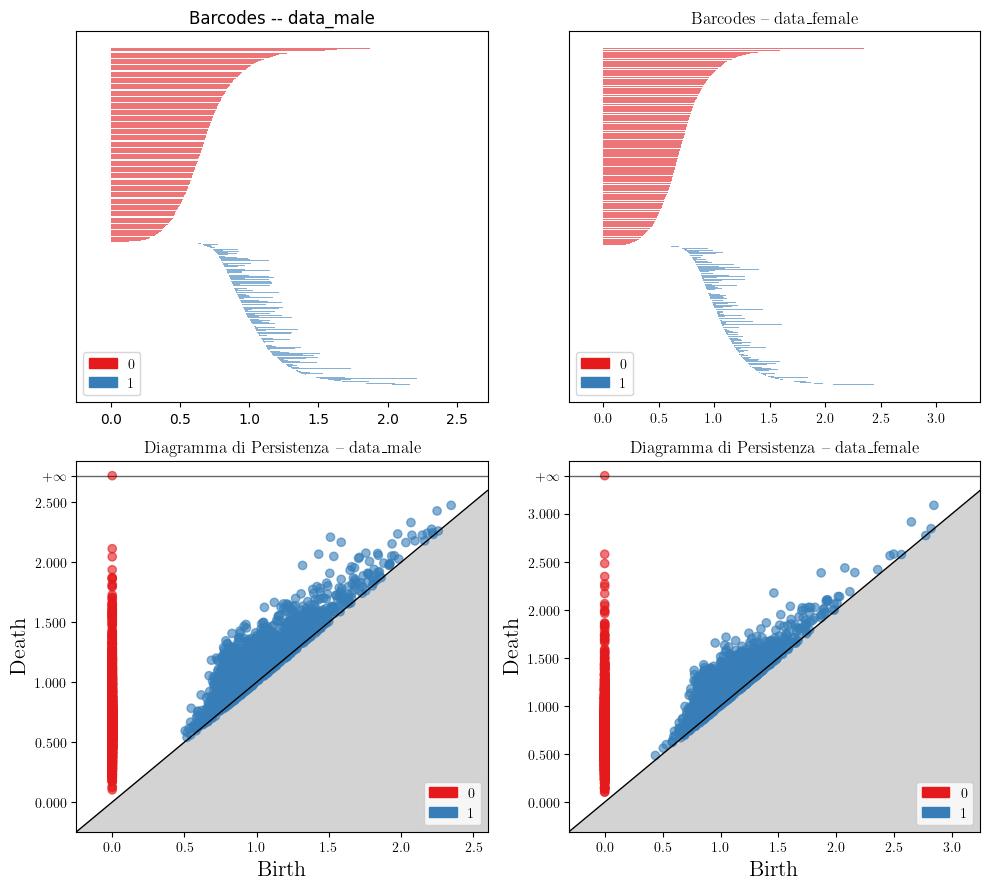

In [17]:
#Barcodes e diagrammi di persistenza con gudhi
plt.figure(figsize=(10, 9))
gd.plot_persistence_barcode(BarCodes_RipsM, legend=True,axes=plt.subplot(221))
plt.title("Barcodes -- data_male")
gd.plot_persistence_barcode(BarCodes_RipsF, legend=True,axes=plt.subplot(222))
plt.title("Barcodes -- data_female")
gd.plot_persistence_diagram(BarCodes_RipsM, legend=True,axes=plt.subplot(223))
plt.title("Diagramma di Persistenza -- data_male")
gd.plot_persistence_diagram(BarCodes_RipsF, legend=True,axes=plt.subplot(224))
plt.title("Diagramma di Persistenza -- data_female")
plt.tight_layout()
plt.show()

In queste rappresentazioni le caratteristiche 0-dimensionali sono in rosso, mentre quelle 1-dimensionali in blu. Le caratteristiche topologiche più persistenti sono i punti più lontani dalla diagonale nel diagramma di persistenza o gli intervalli più lunghi nel barcode. Graficamente i diagrammi (così come i barcode) dei due datasets sono simili. 

Per confrontare due diagrammi di persistenza si può usare la distanza di bottleneck. Essa può essere calcolata tramite la funzione bottleneck_distance() che prende come parametro gli intervalli di persistenza per dimensione. Calcoliamola per la dimensione 1.

In [18]:
IM = Rips_simplex_treeM.persistence_intervals_in_dimension(1)
IF = Rips_simplex_treeF.persistence_intervals_in_dimension(1)

gd.bottleneck_distance(IM, IF)

0.15019752705293676

## Diagrammi di persistenza con Ripser

Un'altra libreria utile e veloce per la TDA in python è scikit-tda. In particolare i due moduli principali di tale libreria per l'omologia persistente sono ripser e persim. Il primo contiene strumenti e metodi utili per il calcolo dell'omologia persistente, il secondo per il confronto, l'analisi e la rappresentazione dei diagrammi di persistenza. 

In [19]:
def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

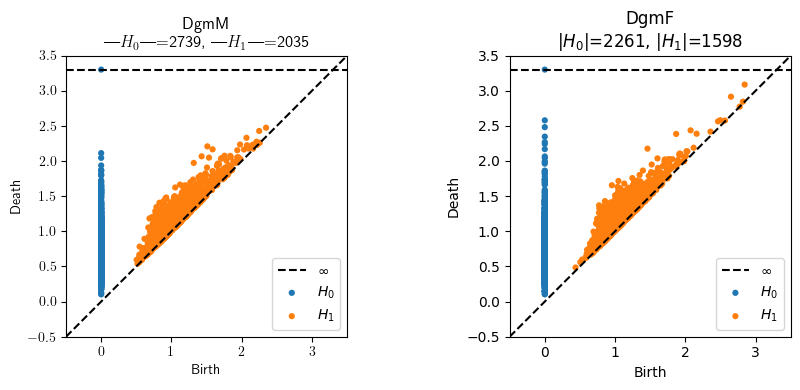

In [20]:
#diagrammi di persistenza con ripser
dgmM = ripser(data_male)['dgms']
dgmF = ripser(data_female)['dgms']

plt.figure(figsize=(9,4))
plot_diagrams(dgmM, xy_range=[-0.5,3.5,-0.5,3.5], ax=plt.subplot(121), title = f"DgmM\n{diagram_sizes(dgmM)}")
plot_diagrams(dgmF, xy_range=[-0.5,3.5,-0.5,3.5], ax=plt.subplot(122), title = f"DgmF\n{diagram_sizes(dgmF)}")
plt.tight_layout()
plt.show()


Si può specificare la massima dimensione dell'omologia che si vuole calcolare con maxdim. Di default ripser calcola solo $H_0$ e $H_1$. Tutto quello che riguarda dimensioni maggiori o uguali a 2 può essere calcolato, ma molto lentamente. Inoltre con il parametro thresh si può specificare un limite massimo per il raggio della filtrazione di Vietoris-Rips e con il parametro coeff=*p* si può specificare il campo dei coefficienti per l'omologia: $\mathbb{Z}/p\mathbb{Z}$.

Il pacchetto Persim contiene inoltre implementazioni di funzioni distanza tra diagrammi di persistenza. In particolare possiamo calcolare la distanza di bottleneck usando il metodo bottleneck() di persim. Esso prende come parametro due diagrammi di persistenza con dimensione dell'omologia fissata. Se si pone matching=True, restituisce anche un matching tra i tanti con distanza di bottleneck minima. Grazie a ciò si può, col metodo bottleneck_matching(), rappresentare graficamente gli abbinamenti. La distanza di bottleneck viene mostrata come una linea rossa, mentri gli altri abbinamenti nel matching come linee verdi.

In [21]:
dgmM1 = ripser(data_male)['dgms'][1]
dgmF1 = ripser(data_female)['dgms'][1]

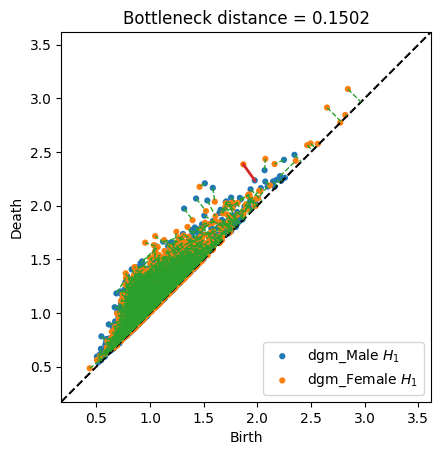

In [22]:
# calcolare e rappresentare la distanza di bottleneck usando persim

distance_bottleneck, matching = persim.bottleneck(dgmM1, dgmF1, matching=True)
persim.bottleneck_matching(dgmM1, dgmF1, matching, labels=['dgm_Male $H_1$', 'dgm_Female $H_1$'])
plt.title(f"Bottleneck distance = {distance_bottleneck:0.4f}",)
plt.show()

## Complessi alfa usando gudhi

Come ultimo esempio sugli stessi datasets, calcoliamo i diagrammi di persistenza e la distanza di bottleneck usando questa volta il complesso alfa. I complessi alfa contengono meno simplessi del complesso di Vietoris-Rips quindi possono essere un opzione migliore dal punto di vista computazionale. Inoltre, essendo i datasets contenuti in $\mathbb{R}^4$, anche i corrispettivi complessi alfa saranno inclusi in $\mathbb{R}^4$. Usando la libreria gudhi i complessi alfa si calcolano velocemente col metodo AlphaComplex(). Essi ci permettono di studiare anche i gruppi di omologia $H_2$ e $H_3$ dei nostri dati.

In [23]:
alpha_complexM = gd.AlphaComplex(points = data_male.to_numpy())
alpha_complexF = gd.AlphaComplex(points = data_female.to_numpy())

In [24]:
st_alphaM = alpha_complexM.create_simplex_tree(max_alpha_square = 4)
st_alphaF = alpha_complexF.create_simplex_tree(max_alpha_square = 4)

In [25]:
st_alphaM.dimension()

4

In [26]:
st_alphaF.dimension()

4

In [27]:
st_alphaM.num_simplices()

437963

In [28]:
st_alphaF.num_simplices()

350485

Il numero totale dei simplessi per il complesso di Vietoris-Rips calcolato precedentemente era dell'ordine di $10^7$, mentre il numero totale dei simplessi nel complesso alfa è dell'ordine di $10^5$, molto più basso.

In [30]:
BarCodes_AlphaM = st_alphaM.persistence()
BarCodes_AlphaF = st_alphaF.persistence()

In [31]:
BarCodes_AlphaM0 = st_alphaM.persistence_intervals_in_dimension(0)
BarCodes_AlphaF0 = st_alphaF.persistence_intervals_in_dimension(0)
BarCodes_AlphaM1 = st_alphaM.persistence_intervals_in_dimension(1)
BarCodes_AlphaF1 = st_alphaF.persistence_intervals_in_dimension(1)
BarCodes_AlphaM2 = st_alphaM.persistence_intervals_in_dimension(2)
BarCodes_AlphaF2 = st_alphaF.persistence_intervals_in_dimension(2)
BarCodes_AlphaM3 = st_alphaM.persistence_intervals_in_dimension(3)
BarCodes_AlphaF3 = st_alphaF.persistence_intervals_in_dimension(3)

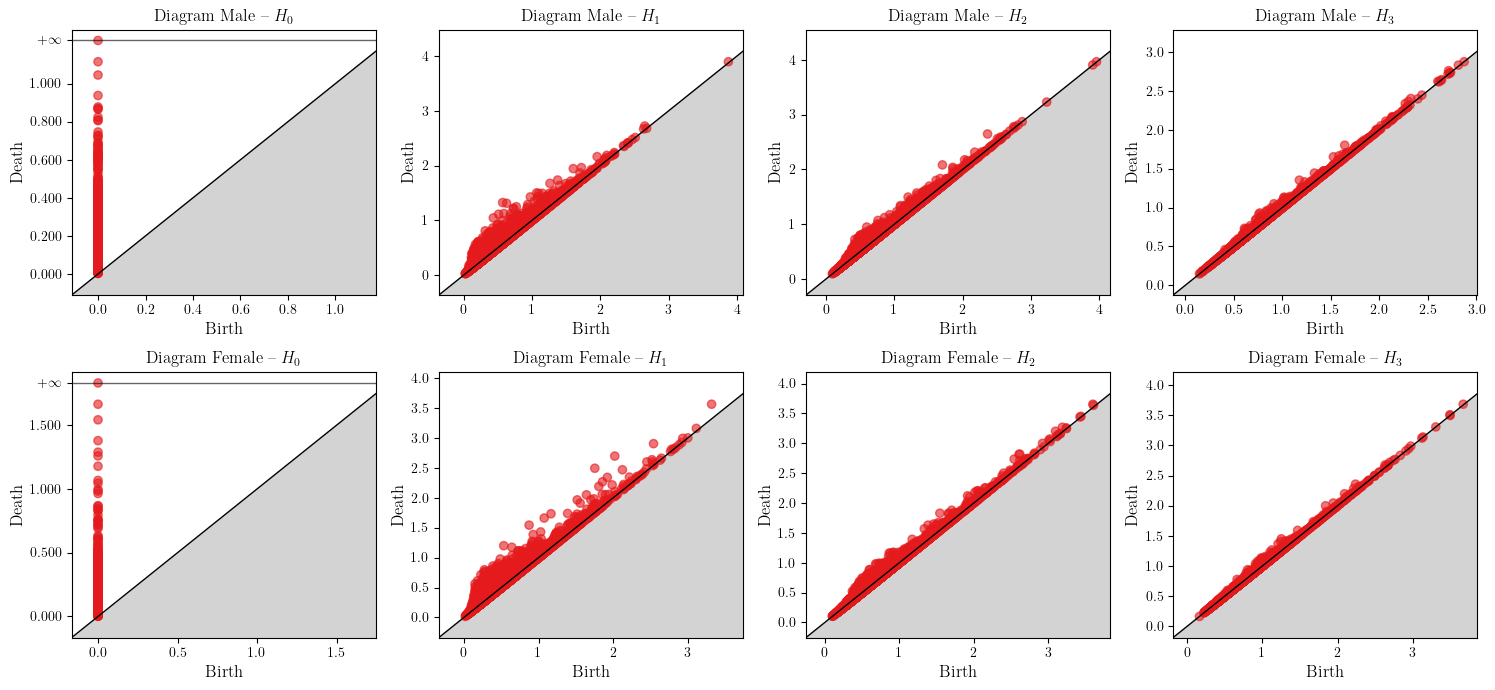

In [36]:
# Diagrammi di persistenza con complessi alfa usando gudhi
plt.figure(figsize=(15, 7))
gd.plot_persistence_diagram(BarCodes_AlphaM0, axes=plt.subplot(241),fontsize=12)
plt.title("Diagram Male -- $H_0$")
gd.plot_persistence_diagram(BarCodes_AlphaM1, axes=plt.subplot(242),fontsize=12)
plt.title("Diagram Male -- $H_1$")
gd.plot_persistence_diagram(BarCodes_AlphaM2, axes=plt.subplot(243),fontsize=12)
plt.title("Diagram Male -- $H_2$")
gd.plot_persistence_diagram(BarCodes_AlphaM3, axes=plt.subplot(244),fontsize=12)
plt.title("Diagram Male -- $H_3$")
gd.plot_persistence_diagram(BarCodes_AlphaF0, axes=plt.subplot(245),fontsize=12)
plt.title("Diagram Female -- $H_0$")
gd.plot_persistence_diagram(BarCodes_AlphaF1, axes=plt.subplot(246),fontsize=12)
plt.title("Diagram Female -- $H_1$")
gd.plot_persistence_diagram(BarCodes_AlphaF2, axes=plt.subplot(247),fontsize=12)
plt.title("Diagram Female -- $H_2$")
gd.plot_persistence_diagram(BarCodes_AlphaF3, axes=plt.subplot(248),fontsize=12)
plt.title("Diagram Female -- $H_3$")
plt.tight_layout()
plt.show()

Oltre a visualizzare i diagrammi di persistenza associati alla filtrazione alfa dei due datasets, per ogni dimensione da 0 a 3, studiamo la distanza di bottleneck tra tali diagrammi per le dimensioni 1, 2 e 3.

In [41]:
# Distanza di Bottleneck
d1 = gd.bottleneck_distance(BarCodes_AlphaM1, BarCodes_AlphaF1)
d2 = gd.bottleneck_distance(BarCodes_AlphaM2, BarCodes_AlphaF2)
d3 = gd.bottleneck_distance(BarCodes_AlphaM3, BarCodes_AlphaF3)
print("d1 = ", str(d1))
print("d2 = ", str(d2))
print("d3 = ", str(d3))

d1 =  0.33287102615475905
d2 =  0.17756722492874027
d3 =  0.08016820736910321
